In [78]:
import os
import shap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import xgboost as xgb
import catboost as cb
from sklearn import tree, svm
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, LeaveOneOut 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from tqdm import tqdm
from sklearn.feature_selection import RFE, RFECV
import division_into_classes as dic
import time

In [2]:
cognitive_indicator = 'corsi'
indicator_folder = "D:/unn/down_syndrome_epigenetic/corsi"
alpha = 0.001

correlation_frame = pd.read_csv(r"D:\unn\down_syndrome_epigenetic\corsi\correlation_frame.txt", sep = '\t', index_col = 0)
methylation_frame = pd.read_csv(r"D:\unn\down_syndrome_epigenetic\corsi\methylation_frame.txt", sep = '\t', index_col = 0)
cognitive_frame = pd.read_csv(r"D:\unn\down_syndrome_epigenetic\corsi\cognitive_frame.txt", sep = '\t', index_col = 0)

In [3]:
classes_all_members, classes_unique_members = dic.division_into_classes (cognitive_indicator, cognitive_frame)
print('Division into classes \nall values:', *classes_all_members, '\nunique values:', *classes_unique_members)
division_method = int(input('\nChoose how to divide into classes:\n1. all values\n2. unique values\n3. manual division\n'))
if division_method == 3:
    print(sorted(list(cognitive_frame[cognitive_indicator])))
    lim1, lim2 = [int(i) for i in input('Enter boundary values: ').split(' ')]
    indicator_classes = dic.division_into_classes(cognitive_indicator, cognitive_frame, division_method, lim1, lim2)
else:
    indicator_classes = dic.division_into_classes(cognitive_indicator, cognitive_frame, division_method)

Division into classes 
all values: 14 8 6 
unique values: 9 13 6

Choose how to divide into classes:
1. all values
2. unique values
3. manual division
2


In [26]:
X = methylation_frame[correlation_frame.index]
y = indicator_classes['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111, stratify = y)
pipeline = make_pipeline(StandardScaler(), QDA())

params = {'quadraticdiscriminantanalysis__reg_param': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]}
grid_pipeline = GridSearchCV(estimator = pipeline, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1,)
grid_pipeline.fit(X_train, y_train)
    
best_params = grid_pipeline.best_params_
cv_err = grid_pipeline.best_score_
y_pred = grid_pipeline.predict(X_test)

print('QDA:', '\nbest params:', best_params, '\nCV error =', cv_err, 
     '\nAccuracy =', accuracy_score(y_test, y_pred), '\nF =', f1_score(y_test, y_pred, average = 'macro'))

QDA: 
best params: {'quadraticdiscriminantanalysis__reg_param': 0.2} 
CV error = 0.45999999999999996 
Accuracy = 0.3333333333333333 
F = 0.3


Variables are collinear


In [25]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'quadraticdiscriminantanalysis', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'quadraticdiscriminantanalysis__priors', 'quadraticdiscriminantanalysis__reg_param', 'quadraticdiscriminantanalysis__store_covariance', 'quadraticdiscriminantanalysis__tol'])

In [68]:
#PCA
X = methylation_frame[correlation_frame.index]
y = indicator_classes['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111, stratify = y)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

components = 17
pca = PCA(n_components = components)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

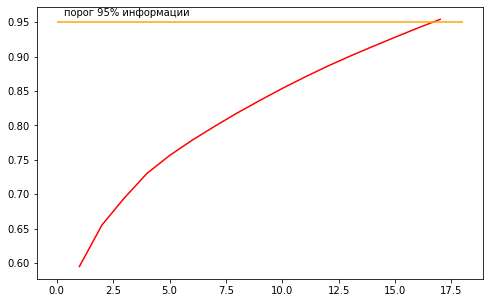

In [69]:
cum_exp_var = []
for k in range(0, len(pca.explained_variance_ratio_)):
    cum_exp_var.append(sum(pca.explained_variance_ratio_[0:k+1]))

plt.figure(figsize = (8, 5))
plt.plot(range(1, components+1), cum_exp_var, color = 'red')
plt.hlines(0.95, 0, components+1, linestyle = '-', color = 'orange')
plt.text(0.3, 0.96, 'порог 95% информации')

plt.show()

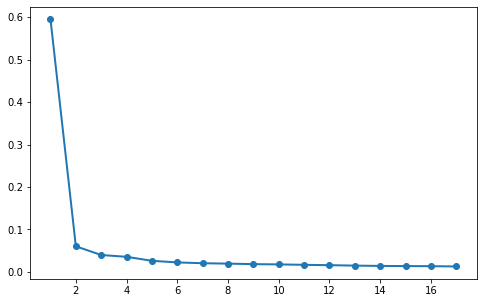

In [70]:
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize = (8, 5))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2)
plt.show()

In [71]:
print(pca.explained_variance_ratio_)

[0.59512102 0.06019864 0.03964247 0.03544293 0.02597482 0.02219141
 0.0202892  0.01933223 0.01815053 0.0175356  0.01652397 0.0156715
 0.01469219 0.01391175 0.01359255 0.01328542 0.01270031]


In [79]:
#RFECV
X = methylation_frame[correlation_frame.index]
y = indicator_classes['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111, stratify = y)

t1 = time.time()
selector = RFECV(estimator = LogisticRegression(), cv = 5, scoring = 'accuracy')
Pipeline(steps = [('features', selector), ('model', model)])

pipeline.fit(X_train, y_train)
t2 = time.time()

#select_features = list(X_train.columns[pipeline.support_])
print(spipeline.n_features_)
print(t2-t1)

KeyboardInterrupt: 

In [82]:
X = methylation_frame[correlation_frame.index]
y = indicator_classes['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111, stratify = y)

rfecv = RFECV(QDA())

pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 111)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = -1)
np.mean(n_scores)

pipeline.fit(X_train,y_train)
print(rfecv.n_features_)


25 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Anaconda\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "D:\Anaconda\lib\site-packages\sklearn\pipeline.py

ValueError: when `importance_getter=='auto'`, the underlying estimator QuadraticDiscriminantAnalysis should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.